In [53]:
import warnings
warnings.simplefilter("ignore")
import pypsa
import time
import logging
import numpy as np
import os 
import sys
import yaml
import pyomo.environ as pyomo_env
import pandas as pd
from scipy.spatial import ConvexHull,  Delaunay
from scipy.interpolate import griddata
from multiprocessing import Lock, Process, Queue, current_process
import queue # imported for using queue.Empty exception
sys.path.append(os.getcwd())
import plotly.graph_objects as go
import plotly.figure_factory as ff
warnings.simplefilter("ignore")

In [2]:

network = pypsa.Network()
network.import_from_hdf5('PyPSA_project/data/networks/euro_00')
dim = 2

bus_list = ['DK','SE','NO','DE','PL','CZ','NL','AT','CH']

bus_list = bus_list[:dim]

for bus in network.buses.index:
    if bus not in bus_list:
        network.remove('Bus',name=bus)
        network.remove('Load',bus)

for link in network.links.index:
    if not (network.links.loc[link].bus0 in bus_list and network.links.loc[link].bus1 in bus_list ):
        network.remove('Link',link)

for generator in network.generators.index:
    if not network.generators.loc[generator].bus in bus_list:
        network.remove('Generator',generator)
        
for generator in network.generators.index:
    if network.generators.loc[generator].type == 'solar':
        network.remove('Generator',generator)

network.snapshots = network.snapshots[0:10]

INFO:pypsa.io:Imported network euro_00 has buses, carriers, generators, global_constraints, links, loads


In [3]:
network.remove('Generator','DK onwind')
network.remove('Generator','DK ocgt')
network.remove('Generator','SE offwind')

In [4]:
network.generators

bus control  type  p_nom_extendable     p_nom_max  carrier  \
name                                                                    
DK offwind  DK      PQ  wind              True  1.013904e+05  offwind   
SE onwind   SE   Slack  wind              True  3.024149e+05   onwind   
SE ocgt     SE      PQ  ocgt              True           inf     ocgt   

            marginal_cost   capital_cost  efficiency  min_up_time  ...  p_set  \
name                                                               ...          
DK offwind       0.020000  295041.156155        1.00            0  ...    0.0   
SE onwind        0.015000  136428.031355        1.00            0  ...    0.0   
SE ocgt         58.384615   47234.561404        0.39            0  ...    0.0   

            q_set  sign  committable  start_up_cost  shut_down_cost  \
name                                                                  
DK offwind    0.0   1.0        False            0.0             0.0   
SE onwind     0.0   1.0        False            0.0             0.0   
SE ocgt       0.0   1.0        False            0.0             0.0   

            ramp_limit_up  ramp_limit_down  ramp_limit_start_up  \
name                                                              
DK offwind            NaN              NaN                  1.0   
SE onwind             NaN              NaN                  1.0   
SE ocgt               NaN              NaN                  1.0   

            ramp_limit_shut_down  
name                              
DK offwind                   1.0  
SE onwind                    1.0  
SE ocgt                      1.0  

[3 rows x 27 columns]

### Initial solution

In [5]:

network.lopf(network.snapshots, 
            solver_name='gurobi'),

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 1229357275.695268
  Upper bound: 1229357275.695268
  Number of objectives: 1
  Number of constraints: 122
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 211
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

(('ok', 'optimal'),)

(<matplotlib.collections.PathCollection at 0x2a3e761cd68>,
 <matplotlib.collections.LineCollection at 0x2a3e754e898>)

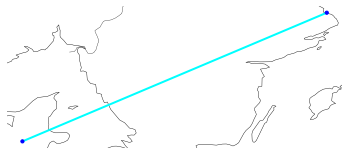

In [6]:
network.plot()

In [7]:
co2_emission = [constraint.body() for constraint in network.model.global_constraints.values()][0]
co2_emission
network.remove('GlobalConstraint',"co2_limit")
target = (1-0.60)*co2_emission
network.add("GlobalConstraint","co2_limit",
      sense="<=",
      carrier_attribute="co2_emissions",
      constant=target)


In [8]:
network.lopf(network.snapshots, 
            solver_name='gurobi')
old_objective_value = network.model.objective()

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 3343442756.6917167
  Upper bound: 3343442756.6917167
  Number of objectives: 1
  Number of constraints: 122
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 211
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

In [9]:
network.generators.p_nom_opt
inital_solution = []
"""
for var_type in ['ocgt','wind','solar']:
    filter1 = network.generators.type==var_type
    inital_solution.append(sum(network.generators.p_nom_opt[filter1]))
    """
inital_solution = network.generators.p_nom_opt
inital_solution

name
DK offwind        0.000000
SE onwind     19242.427111
SE ocgt       10578.323117
Name: p_nom_opt, dtype: float64

### Function definitions

In [10]:
def direction_search(network, snapshots,options,direction): #  MGA_slack = 0.05, point=[0,0,0],dim=3,old_objective_value=0):
# Identify the nonzero decision variables that should enter the MGA objective function.
    old_objective_value = options['old_objective_value']
    dim = options['dim']
    MGA_slack = 0.1

    if dim == 3:
        generators = [gen_p for gen_p in network.model.generator_p_nom]
        types = ['ocgt','wind','olar']
        variables = []
        for i in range(3):
            gen_p_type = [gen_p  for gen_p in generators if gen_p[-4:]==types[i]]
            variables.append(sum([network.model.generator_p_nom[gen_p] for gen_p in gen_p_type]))
            
                             
    elif dim == 2:
        generators = [gen_p for gen_p in network.model.generator_p_nom]
        types = ['ocgt','wind','olar']
        variables = []
        for i in range(3):
            gen_p_type = [gen_p  for gen_p in generators if gen_p[-4:]==types[i]]
            variables.append(sum([network.model.generator_p_nom[gen_p] for gen_p in gen_p_type]))
        slack = 0    
        point = options['point']
        #point = inital_solution
        network.model.ocgt_constraint_u = pyomo_env.Constraint(expr=variables[0]== point[0])
        #network.model.ocgt_constraint_l = pyomo_env.Constraint(expr=variables[0]>= inital_solution[0]+1000-slack)
        network.model.wind_constraint_u = pyomo_env.Constraint(expr=variables[1]== point[1])
        #network.model.wind_constraint_l = pyomo_env.Constraint(expr=variables[1]>= inital_solution[1]+1000-slack)
        #network.model.solar_constraint_u = pyomo_env.Constraint(expr=variables[2]== point[2])
        #network.model.solar_constraint_l = pyomo_env.Constraint(expr=variables[2]>= inital_solution[2]+1000-slack)
        """                                                     
        variables = []
        for bus in network.buses.index:
            var = []
            for generator in network.model.generator_p_nom:
                if network.generators.loc[generator].type == 'wind' and network.generators.loc[generator].bus == bus :
                    var.append(network.model.generator_p_nom[generator])
            variables.append(sum(var))
            print(sum(var))    """       
        variables = [network.model.generator_p_nom[gen_p] for gen_p in network.model.generator_p_nom]
                             
    else :
        variables = [network.model.generator_p_nom[gen_p] for gen_p in network.model.generator_p_nom]
        
    objective = 0
    for i in range(len(variables)):
        #print(variables[i])
        objective += direction[i]*variables[i]

    print(objective)
    # Add the new MGA objective function to the model.
    #objective += network.model.objective.expr * 1e-9
    network.model.mga_objective = pyomo_env.Objective(expr=objective)
    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()
    # Add the MGA slack constraint.
    network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
                                          (1 + MGA_slack) * old_objective_value)


In [11]:
def rand_split(n):
    
    rand_list = np.random.random(n-1)
    rand_list.sort()
    rand_list = np.concatenate([[0],rand_list,[1]])
    rand_list = np.diff(rand_list)

    return rand_list

def create_interior_points(hull,m):
    #m = 20

    # Generate Delunay triangulation of hull
    try :
        tri = Delaunay(hull.points[hull.vertices])#,qhull_options='Qs')#,qhull_options='A-0.999')
    except : 
        points = np.append(hull.points[hull.vertices],[np.mean(hull.points,axis=0)],axis=0)            
        tri = Delaunay(points,qhull_options='Qs')
    # Distribute number of points based on simplex size 
    tri.volumes = []
    for i in range(len(tri.simplices)):
        try :
            tri.volumes.append(ConvexHull(tri.points[tri.simplices[i,:]]).volume)
        except : 
            tri.volumes.append(0)
    tri.volumes = np.array(tri.volumes)
    tri.volumes_norm = tri.volumes/sum(tri.volumes)

    tri.n_points_in_tri =  (tri.volumes_norm*m).astype(int)
    # Generate interrior points of each simplex
    interrior_points = []
    for i in range(len(tri.simplices)):
        tri_face = tri.points[tri.simplices[i,:]]
        for j in range(tri.n_points_in_tri[i]):
            dim = len(tri.points[0,:])
            rand_list = rand_split(dim+1)

            new_point = sum([face*rand_n for face,rand_n in zip(tri_face,rand_list)])
            interrior_points.append(new_point)
    interrior_points = np.array(interrior_points)
    return interrior_points

### MGA with $\sum$ variables

In [12]:
#logging.disable()
data_detail_sum = []
options = dict(dim=3,old_objective_value=old_objective_value)
dim=3
old_volume = 0
epsilon = 1
while epsilon > 0.05:
    data_detail = list(data_detail_sum)
    if len(data_detail_sum)<=1 : # if only original solution exists, max/min directions are chosen
        directions = np.concatenate([np.diag(np.ones(dim)),-np.diag(np.ones(dim))],axis=0)
    else : # Otherwise search in directions normal to faces
        directions = np.array(hull.equations)[:,0:-1]
    # Itterate over directions in batch 
    for direction in directions:
        print(direction)
        direction = np.concatenate([direction,[0]])
        network.lopf(network.snapshots,                                 
                        solver_name='gurobi',                                 
                        extra_functionality=lambda network,                                 
                        snapshots: direction_search(network,snapshots,options,direction))

        var = []
        for var_type in ['ocgt','wind']:#,'solar']:
            filter1 = network.generators.type==var_type
            var.append(sum(network.generators.p_nom_opt[filter1]))
        data_detail_sum.append(var)
    

    hull = ConvexHull(data_detail_sum)#,qhull_options='QJ')
    
    delta_v = hull.volume - old_volume
    old_volume = hull.volume
    epsilon = delta_v/hull.volume
    
    print(epsilon)


data_detail_sum = np.array(data_detail_sum)

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


[1. 0. 0.]
generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8813.823433659387
  Upper bound: 8813.823433659387
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 16222.500008262716
  Upper bound: 16222.500008262716
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.opf:Solving model using gurobi


0.0
    solver failure.


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.opf:Solving model using gurobi


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17656.705253285883
  Upper bound: -17656.705253285883
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Solving model using gurobi


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22278.50941233782
  Upper bound: -22278.50941233782
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.opf:Solving model using gurobi



    solver failure.


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.opf:Solving model using gurobi


-0.9522170422862258*generator_p_nom[SE ocgt] - 0.30542217401438304*(generator_p_nom[DK offwind] + generator_p_nom[SE onwind])


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22690.079574295363
  Upper bound: -22690.079574295363
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Solving model using gurobi


0.35934977585145833*generator_p_nom[SE ocgt] - 0.933202946092385*(generator_p_nom[DK offwind] + generator_p_nom[SE onwind])


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17588.053218251986
  Upper bound: -17588.053218251986
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Solving model using gurobi


-0.9994483758897504*generator_p_nom[SE ocgt] + 0.03321059968353799*(generator_p_nom[DK offwind] + generator_p_nom[SE onwind])


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17007.912845244384
  Upper bound: -17007.912845244384
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Solving model using gurobi


0.3279659486562107*generator_p_nom[SE ocgt] + 0.9446895450474889*(generator_p_nom[DK offwind] + generator_p_nom[SE onwind])


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 18543.947407932774
  Upper bound: 18543.947407932774
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

In [13]:
hull_sum = ConvexHull(data_detail_sum)
interior_points_sum = create_interior_points(hull_sum,5000)

In [14]:
fig = go.Figure()



fig.add_trace(go.Scatter(x=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,1],
                          y=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,0],
                          #z=data_detail_sum[:,2],
                          mode='lines'))

fig.add_trace(go.Scatter(x=data_detail_sum[:,1],
                          y=data_detail_sum[:,0],
                          #z=data_detail_sum[:,2],
                          mode='markers',name='MGA solutions'))

fig.add_trace(go.Scatter(y=[inital_solution[2]],
                          x=[inital_solution[0]+inital_solution[1]],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Initial_solution'))

fig.add_trace(go.Scatter(x=interior_points_sum[:,1],
                          y=interior_points_sum[:,0],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Interrior_points'))
fig.update_yaxes(title_text='$x_3$')
fig.update_xaxes(title_text='$x_1+x_2$')


In [15]:
import matplotlib.pyplot as plt
import scipy.stats as stats
def plot_hist(ax,x,w=[] ,color='C1'):
    if len(w)<=0 :
        w = np.ones(len(x))
    kde1 = stats.gaussian_kde(x,weights=w)
    xx = np.linspace(7000, 23000, 1000)
    ax.hist(x=x,stacked=False,weights=w,bins=20,density=True,histtype='stepfilled', alpha=0.5,color=color);
    ax.plot(xx, kde1(xx),color=color)
    return ax

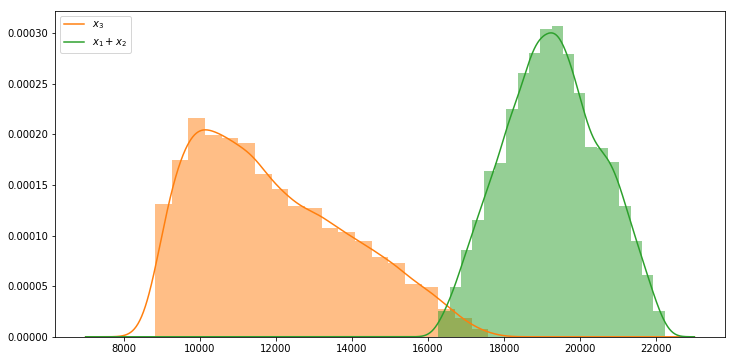

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax.legend(['$x_3$','$x_1+x_2$']);
ax.xlabel('MW installed capacity')

### Multiplicity MGA

In [17]:
sample_points = create_interior_points(hull_sum,20)
sample_points = np.concatenate([sample_points,data_detail_sum])

In [18]:
weights = []
for point in sample_points : 
    data_detail = []
    dim = 3
    old_volume = 0
    epsilon = 1
    while epsilon > 0.05:
        if len(data_detail)<=1 : # if only original solution exists, max/min directions are chosen
            directions = np.concatenate([np.diag(np.ones(dim)),-np.diag(np.ones(dim))],axis=0)
        else : # Otherwise search in directions normal to faces
            directions = np.array(hull.equations)[:,0:-1]
        # Itterate over directions in batch 
        for direction in directions:
            #print(direction)
            network = network.copy()
            #options = dict(dim=2,old_objective_value=old_objective_value,point=data_detail_sum[1,:])
            options = dict(dim=2,old_objective_value=old_objective_value,point=point)
            network.lopf(network.snapshots,                                 
                            solver_name='gurobi',                                 
                            extra_functionality=lambda network,                                 
                            snapshots: direction_search(network,snapshots,options,direction),
                            solver_options=dict(threads=4,method=2))

            var = []
            for country in bus_list:
                filter1 = network.generators.bus==country
                filter2 = network.generators.type=='wind'
                filter = [a and b for a,b in zip(filter1,filter2)]
                var.append(sum(network.generators.p_nom_opt[filter]))
            data_detail.append(network.generators.p_nom_opt.values)
        #hull = ConvexHull(data_detail)#,qhull_options='QJ')

        #delta_v = hull.volume - old_volume
        #old_volume = hull.volume
        #epsilon = delta_v/hull.volume
        epsilon = 0
        print(epsilon)


    data_detail = np.array(data_detail)
    diff = np.max(data_detail,axis=0)-np.min(data_detail,axis=0)
    weight = np.linalg.norm(diff)
    weights.append(weight)

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 1599.373105718734
  Upper bound: 1599.373105718734
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 15887.716340174466
  Upper bound: 15887.716340174466
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14776.292286902373
  Upper bound: 14776.292286902373
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -2474.6970076987554
  Upper bound: -2474.6970076987554
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -16763.04024215449
  Upper bound: -16763.04024215449
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -14776.292286902373
  Upper bound: -14776.292286902373
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 1162.2369844829334
  Upper bound: 1162.2369844829334
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 15541.356283764899
  Upper bound: 15541.356283764899
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 12771.68628491194
  Upper bound: 12771.68628491194
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -3061.5799299621663
  Upper bound: -3061.5799299621663
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17440.699229244132
  Upper bound: -17440.699229244132
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12771.68628491194
  Upper bound: -12771.68628491194
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 686.1580068994825
  Upper bound: 686.1580068994825
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 16750.46282725051
  Upper bound: 16750.46282725051
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14134.2216082054
  Upper bound: 14134.2216082054
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was sol

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -2114.4235537091795
  Upper bound: -2114.4235537091795
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18178.72837406021
  Upper bound: -18178.72837406021
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -14134.2216082054
  Upper bound: -14134.2216082054
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 1237.2932598442098
  Upper bound: 1237.2932598442098
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 15262.347757912266
  Upper bound: 15262.347757912266
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 12359.314979666047
  Upper bound: 12359.314979666047
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -3299.2906779071454
  Upper bound: -3299.2906779071454
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17324.345175975202
  Upper bound: -17324.345175975202
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12359.314979666047
  Upper bound: -12359.314979666047
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 986.7554428789047
  Upper bound: 986.7554428789047
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 16692.525240171795
  Upper bound: 16692.525240171795
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14850.825854150005
  Upper bound: 14850.825854150005
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 

INFO:pypsa.opf:Optimization successful



- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.0070018768310546875
  Error rc: 0
  Time: 0.163926362991333
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -2006.9651616917477
  Upper bound: -2006.9651616917477
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 

INFO:pypsa.opf:Optimization successful


65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.00799560546875
  Error rc: 0
  Time: 0.16890311241149902
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17712.734958984638
  Upper bound: -17712.734958984638
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -14850.825854150005
  Upper bound: -14850.825854150005
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 1349.9978575641398
  Upper bound: 1349.9978575641398
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14880.55306611509
  Upper bound: 14880.55306611509
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11823.072040170193
  Upper bound: 11823.072040170193
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -3619.072574326381
  Upper bound: -3619.072574326381
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17149.62778287733
  Upper bound: -17149.62778287733
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -11823.072040170193
  Upper bound: -11823.072040170193
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------


INFO:pypsa.opf:Optimization successful


#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 2083.2803855853936
  Upper bound: 2083.2803855853936
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.0069942474365234375
  Error rc: 0
  Time: 0.16690421104431152
# ----------------------------------------------------------
#   Solution Informat

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14323.398395559148
  Upper bound: 14323.398395559148
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 12640.101905900385
  Upper bound: 12640.101905900385
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -3772.757463841089
  Upper bound: -3772.757463841089
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -16012.875473814842
  Upper bound: -16012.875473814842
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12640.101905900385
  Upper bound: -12640.101905900385
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 3438.2926038155947
  Upper bound: 3438.2926038155947
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 12559.851996486981
  Upper bound: 12559.851996486981
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 

INFO:pypsa.opf:Optimization successful


65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.006008148193359375
  Error rc: 0
  Time: 0.17091584205627441
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10637.533275454452
  Upper bound: 10637.533275454452
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -4790.743370052727
  Upper bound: -4790.743370052727
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -13912.302762724112
  Upper bound: -13912.302762724112
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -10637.533275454452
  Upper bound: -10637.533275454452
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17000.042460509718
  Upper bound: 17000.042460509718
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 12551.339029378754
  Upper bound: 12551.339029378754
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -2283.3138071580497
  Upper bound: -2283.3138071580497
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19283.35626766777
  Upper bound: -19283.35626766777
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12551.339029378754
  Upper bound: -12551.339029378754
  Number of objectives: 1


INFO:pypsa.opf:Optimization successful


  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.00699615478515625
  Error rc: 0
  Time: 0.16990160942077637
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
0


INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 607.5665276235
  Upper bound: 607.5665276235
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved 

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 15648.516443398546
  Upper bound: 15648.516443398546
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10379.069557610645
  Upper bound: 10379.069557610645
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -3468.94816669039
  Upper bound: -3468.94816669039
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18509.898082465435
  Upper bound: -18509.898082465435
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -10379.069557610645
  Upper bound: -10379.069557610645
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optim

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 20594.743175360753
  Upper bound: 20594.743175360753
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11247.355243998314
  Upper bound: 11247.355243998314
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -497.96323706166754
  Upper bound: -497.96323706166754
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -21092.70641242242
  Upper bound: -21092.70641242242
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -11247.355243998314
  Upper bound: -11247.355243998314
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 2281.9446359448125
  Upper bound: 2281.9446359448125
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17024.02498712151
  Upper bound: 17024.02498712151
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9182.484035388545
  Upper bound: 9182.484035388545
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -2928.3509298392637
  Upper bound: -2928.3509298392637
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17670.43128101596
  Upper bound: -17670.43128101596
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9182.484035388545
  Upper bound: -9182.484035388545
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 2514.250531336678
  Upper bound: 2514.250531336678
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17377.322530789537
  Upper bound: 17377.322530789537
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8972.810672856709
  Upper bound: 8972.810672856709
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -2770.4071814580384
  Upper bound: -2770.4071814580384
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17633.479180910897
  Upper bound: -17633.479180910897
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -8972.810672856709
  Upper bound: -8972.810672856709
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 21414.9207782604
  Upper bound: 21414.9207782604
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information


INFO:pypsa.opf:Optimization successful


# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.00699615478515625
  Error rc: 0
  Time: 0.17090153694152832
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9276.52306387962
  Upper bound: 9276.52306387962
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was sol

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -420.38924184048653
  Upper bound: -420.38924184048653
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -21835.31002010088
  Upper bound: -21835.31002010088
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9276.52306387962
  Upper bound: -9276.52306387962
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17736.872308858798
  Upper bound: 17736.872308858798
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 13691.163247365013
  Upper bound: 13691.163247365013
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -1644.424101127147
  Upper bound: -1644.424101127147
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19381.296409985946
  Upper bound: -19381.296409985946
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -13691.163247365013
  Upper bound: -13691.163247365013
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 96.94602758541794
  Upper bound: 96.94602758541794
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19371.211015636487
  Upper bound: 19371.211015636487
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9632.62337658225
  Upper bound: 9632.62337658225
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was sol

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -1515.8583035966658
  Upper bound: -1515.8583035966658
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20790.123291647735
  Upper bound: -20790.123291647735
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9632.62337658225
  Upper bound: -9632.62337658225
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19952.828641018277
  Upper bound: 19952.828641018277
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14527.119315114236
  Upper bound: 14527.119315114236
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -214.57167726647717
  Upper bound: -214.57167726647717
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20167.400318284755
  Upper bound: -20167.400318284755
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -14527.119315114236
  Upper bound: -14527.119315114236
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 18076.78975223201
  Upper bound: 18076.78975223201
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 12981.480085163508
  Upper bound: 12981.480085163508
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -1591.057565476284
  Upper bound: -1591.057565476284
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19667.847317708292
  Upper bound: -19667.847317708292
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12981.480085163508
  Upper bound: -12981.480085163508
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19607.242144518477
  Upper bound: 19607.242144518477
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14628.750537972528
  Upper bound: 14628.750537972528
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -391.6097220607601
  Upper bound: -391.6097220607601
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19998.851866579236
  Upper bound: -19998.851866579236
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -14628.750537972528
  Upper bound: -14628.750537972528
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 3879.050316294711
  Upper bound: 3879.050316294711
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 15462.31083410486
  Upper bound: 15462.31083410486
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8813.823433659387
  Upper bound: 8813.823433659387
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -3879.0503162947116
  Upper bound: -3879.0503162947116
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -15462.31083410486
  Upper bound: -15462.31083410486
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -8813.823433659387
  Upper bound: -8813.823433659387
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 5493.968777438327
  Upper bound: 5493.968777438327
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10728.531230824377
  Upper bound: 10728.531230824377
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9814.193420940173
  Upper bound: 9814.193420940173
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -5493.968777438338
  Upper bound: -5493.968777438338
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 

INFO:pypsa.opf:Optimization successful


65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.0069980621337890625
  Error rc: 0
  Time: 0.17290139198303223
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -10728.531230824385
  Upper bound: -10728.531230824385
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9814.193420940173
  Upper bound: -9814.193420940173
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.42711079336
  Upper bound: 19242.42711079336
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17656.705253285883
  Upper bound: 17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9.311705171163917e-12
  Upper bound: -9.311705171163917e-12
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17656.705253285883
  Upper bound: -17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.42711079336
  Upper bound: 19242.42711079336
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17656.705253285883
  Upper bound: 17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9.311705171163917e-12
  Upper bound: -9.311705171163917e-12
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17656.705253285883
  Upper bound: -17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optim

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 22278.509412337822
  Upper bound: 22278.509412337822
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8911.421726369195
  Upper bound: 8911.421726369195
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 4.018393229432405e-12
  Upper bound: 4.018393229432405e-12
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22278.50941233782
  Upper bound: -22278.50941233782
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -8911.421726369195
  Upper bound: -8911.421726369195
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.42711079336
  Upper bound: 19242.42711079336
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17656.705253285883
  Upper bound: 17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9.311705171163917e-12
  Upper bound: -9.311705171163917e-12
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17656.705253285883
  Upper bound: -17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.42711079336
  Upper bound: 19242.42711079336
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17656.705253285883
  Upper bound: 17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9.311705171163917e-12
  Upper bound: -9.311705171163917e-12
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17656.705253285883
  Upper bound: -17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 22278.509412337804
  Upper bound: 22278.509412337804
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8911.421726369197
  Upper bound: 8911.421726369197
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -8.03678645886481e-12
  Upper bound: -8.03678645886481e-12
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22278.50941233781
  Upper bound: -22278.50941233781
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -8911.421726369197
  Upper bound: -8911.421726369197
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.42711079336
  Upper bound: 19242.42711079336
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17656.705253285883
  Upper bound: 17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9.311705171163917e-12
  Upper bound: -9.311705171163917e-12
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17656.705253285883
  Upper bound: -17656.705253285883
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 5493.968777438327
  Upper bound: 5493.968777438327
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10728.531230824377
  Upper bound: 10728.531230824377
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9814.193420940173
  Upper bound: 9814.193420940173
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -5493.968777438338
  Upper bound: -5493.968777438338
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -10728.531230824385
  Upper bound: -10728.531230824385
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9814.193420940173
  Upper bound: -9814.193420940173
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,1],
                          y=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,0],
                          #z=data_detail_sum[:,2],
                          mode='lines'))

fig.add_trace(go.Scatter(x=sample_points[:,1],
                          y=sample_points[:,0],
                          #z=[inital_solution[2]+500],
                          mode='markers',
                            marker=dict(color=weights,size=10,colorbar={'thickness':20,'title':'Scenario cost'})))
fig.update_yaxes(title_text='$x_3$')
fig.update_xaxes(title_text='$x_1+x_2$')

In [20]:
interior_weights = griddata(sample_points, 
                                    weights, 
                                    interior_points_sum,
                                    method='linear')


In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,1],
                          y=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,0],
                          #z=data_detail_sum[:,2],
                          mode='lines'))
fig.add_trace(go.Scatter(x=interior_points_sum[:,1],
                          y=interior_points_sum[:,0],
                          #z=[inital_solution[2]+500],
                          mode='markers',
                            marker=dict(color=interior_weights,size=10,colorbar={'thickness':20,'title':'Scenario cost'})))
fig.update_yaxes(title_text='$x_3$')
fig.update_xaxes(title_text='$x_1+x_2$')

In [25]:
import matplotlib.pyplot as plt
import scipy.stats as stats
def plot_hist(ax,x,w=[] ,color='C1'):
    if len(w)<=0 :
        w = np.ones(len(x))
    kde1 = stats.gaussian_kde(x,weights=w)
    xx = np.linspace(7000, 23000, 1000)
    ax.hist(x=x,stacked=False,weights=w,bins=20,density=True,histtype='stepfilled', alpha=0.5,color=color);
    ax.plot(xx, kde1(xx),color=color)
    return ax

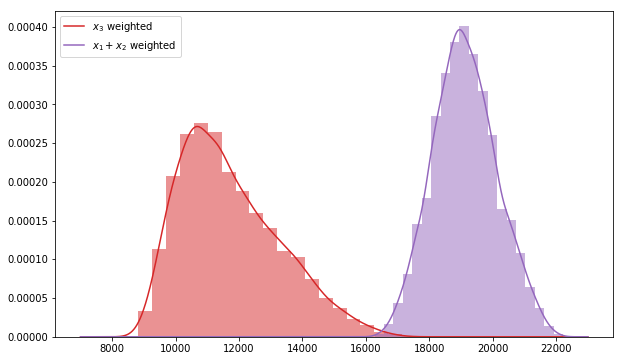

In [47]:
fig, ax = plt.subplots(figsize=(10,6))
#ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
#ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax = plot_hist(ax,interior_points_sum[:,0],color='C3',w=interior_weights)
ax = plot_hist(ax,interior_points_sum[:,1],color='C4',w=interior_weights)
ax.legend(['$x_3$ weighted','$x_1+x_2$ weighted']);
#fig.xlabel('MW installed capacity')

### True Solution

In [30]:
data_detail_full = []
dim=10
old_volume = 0
epsilon = 1
while epsilon > 0.05:
    if len(data_detail_full)<=1 : # if only original solution exists, max/min directions are chosen
        directions = np.concatenate([np.diag(np.ones(3)),-np.diag(np.ones(3))],axis=0)
    else : # Otherwise search in directions normal to faces
        directions = np.array(hull.equations)[:,0:-1]
    # Itterate over directions in batch 
    for direction in directions:
        print(direction)
        direction = np.concatenate([direction,[0]])
        network = network.copy()
        options = dict(dim=5,old_objective_value=old_objective_value)
        network.lopf(network.snapshots,                                 
                        solver_name='gurobi',                                 
                        extra_functionality=lambda network,                                 
                        snapshots: direction_search(network,snapshots,options,direction))

        data_detail_full.append(network.generators.p_nom_opt)
    

    hull = ConvexHull(data_detail_full)#,qhull_options='QJ')
    
    delta_v = hull.volume - old_volume
    old_volume = hull.volume
    epsilon = delta_v/hull.volume
    
    print(epsilon)


data_detail_full = np.array(data_detail_full)

[1. 0. 0.]


INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10728.53123082438
  Upper bound: 10728.53123082438
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8813.823433659387
  Upper bound: 8813.823433659387
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -5508.164803605384
  Upper bound: -5508.164803605384
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22278.50941233782
  Upper bound: -22278.50941233782
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17656.705253285883
  Upper bound: -17656.705253285883
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.9006118461265674*generator_p_nom[DK offwind] + 0.36219442248569833*generator_p_nom[SE onwind] + 0.2402363480756972*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9510.797488965745
  Upper bound: 9510.797488965745
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.8577074499218995*generator_p_nom[DK offwind] + 0.4857008367708122*generator_p_nom[SE onwind] + 0.16861977199784423*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11129.777381290874
  Upper bound: 11129.777381290874
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.8728916952757468*generator_p_nom[DK offwind] + 0.13010770535388932*generator_p_nom[SE onwind] + 0.4702468217076839*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 7089.173482066215
  Upper bound: 7089.173482066215
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.8881009292387557*generator_p_nom[DK offwind] - 0.43422512816743236*generator_p_nom[SE onwind] - 0.15074905489997534*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -11495.078904227199
  Upper bound: -11495.078904227199
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.8577074499218995*generator_p_nom[DK offwind] + 0.4857008367708122*generator_p_nom[SE onwind] + 0.16861977199784423*generator_p_nom[SE ocgt]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11129.777381290874
  Upper bound: 11129.777381290874
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -5508.164803605384
  Upper bound: -5508.164803605384
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.9305893496301513*generator_p_nom[DK offwind] + 0.34715797511828006*generator_p_nom[SE onwind] + 0.11612408306078302*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 7908.560104405156
  Upper bound: 7908.560104405156
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.8577606866047753*generator_p_nom[DK offwind] + 0.4855808941395651*generator_p_nom[SE onwind] + 0.16869439754160415*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11128.258807066286
  Upper bound: 11128.258807066286
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.8402457188941314*generator_p_nom[DK offwind] - 0.5422058021453516*generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12079.537066519393
  Upper bound: -12079.537066519393
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6133494092443668*generator_p_nom[DK offwind] - 0.7115470640275712*generator_p_nom[SE onwind] + 0.3427875112271887*generator_p_nom[SE ocgt]
# ==========================================================


INFO:pypsa.opf:Optimization successful


# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12797.483888181585
  Upper bound: -12797.483888181585
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optim

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.9256731597432178*generator_p_nom[DK offwind] + 0.03318578386857923*generator_p_nom[SE onwind] + 0.3768658980062209*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 4097.740749692225
  Upper bound: 4097.740749692225
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

In [38]:
hull_full = ConvexHull(data_detail_full)
interior_points_full = create_interior_points(hull_full,5000)

In [39]:
fig = go.Figure()


fig.add_trace(go.Scatter3d(x=data_detail_full[:,0],
                          y=data_detail_full[:,1],
                          z=data_detail_full[:,2],
                          mode='markers',name='MGA solutions'))

fig.add_trace(go.Scatter3d(x=interior_points_full[:,0],
                          y=interior_points_full[:,1],
                          z=interior_points_full[:,2],
                          mode='markers',marker=dict(size=2)))

"""
fig.add_trace(go.Scatter(y=[inital_solution[0]+inital_solution[1]],
                          x=[inital_solution[2]],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Initial_solution'))


                          
                          
fig.add_trace(go.Scatter3d(x=hull.points[np.append(hull.vertices,hull.vertices[0])][:,0],
                          y=hull.points[np.append(hull.vertices,hull.vertices[0])][:,1],
                          z=hull.points[np.append(hull.vertices,hull.vertices[0])][:,2],
                          mode='lines'))
                          """
fig.update_layout(scene = dict(
                    xaxis_title='x1',
                    yaxis_title='x2',
                    zaxis_title='x3'))
fig.show()

In [35]:
fig = go.Figure()



fig.add_trace(go.Scatter(x=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,0],
                          y=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,1],
                          #z=data_detail_sum[:,2],
                          mode='lines'))

fig.add_trace(go.Scatter(y=data_detail_full[:,0]+data_detail_full[:,1],
                          x=data_detail_full[:,2],
                          #z=data_detail_sum[:,2],
                          mode='markers',name='MGA solutions'))

fig.add_trace(go.Scatter(y=[inital_solution[0]+inital_solution[1]],
                          x=[inital_solution[2]],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Initial_solution'))

fig.add_trace(go.Scatter(y=interior_points_full[:,0]+interior_points_full[:,1],
                          x=interior_points_full[:,2],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Interrior_points'))
fig.update_yaxes(title_text='$x_3$')
fig.update_xaxes(title_text='$x_1+x_2$')

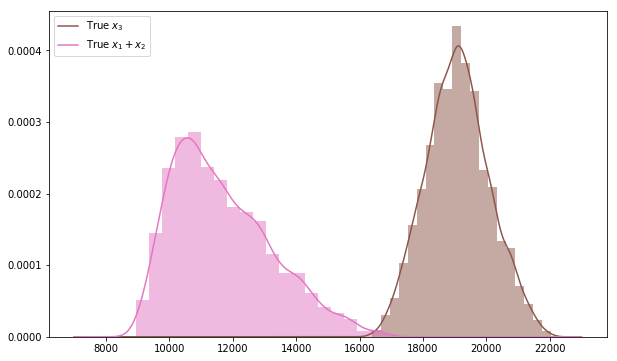

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
ax = plot_hist(ax,interior_points_full[:,0]+interior_points_full[:,1],color='C5')
ax = plot_hist(ax,interior_points_full[:,2],color='C6')
ax.legend(['True $x_3$','True $x_1+x_2$']);

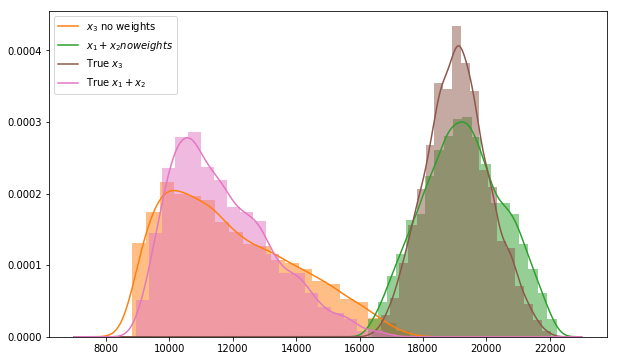

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax = plot_hist(ax,interior_points_full[:,0]+interior_points_full[:,1],color='C5')
ax = plot_hist(ax,interior_points_full[:,2],color='C6')
ax.legend(['$x_3$ no weights','$x_1+x_2 no weights$','True $x_3$','True $x_1+x_2$']);

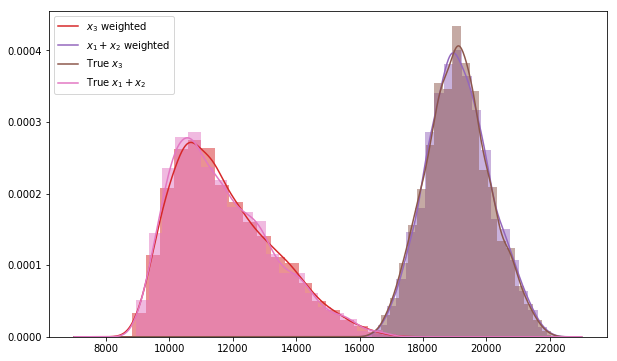

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
#ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
#ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax = plot_hist(ax,interior_points_sum[:,0],color='C3',w=interior_weights)
ax = plot_hist(ax,interior_points_sum[:,1],color='C4',w=interior_weights)
ax = plot_hist(ax,interior_points_full[:,0]+interior_points_full[:,1],color='C5')
ax = plot_hist(ax,interior_points_full[:,2],color='C6')
ax.legend(['$x_3$ weighted','$x_1+x_2$ weighted','True $x_3$','True $x_1+x_2$']);

### Visualization of problem

In [49]:
n = 3
a1 = sample_points[n,0]
a2 = sample_points[n,1]
print(a1,a2)
s,t = np.meshgrid([1000,20000],[1001,20000])
s = np.reshape(s,[4])
t = np.reshape(t,[4])


12359.314979666047 18561.638435819412


In [50]:
P1 = np.array([0,0.,a1])
A1 = np.array([1,0.,0])
B1 = np.array([0,1,0])

P2 = np.array([a2,0.,0])
A2 = np.array([0,-0.001,1])
B2 = np.array([-1,1,0])

In [51]:
p1 = []
p2 = []
l1 = []
for i in range(len(s)):
    p1.append( P1 +s[i]*A1 + t[i]*B1 )
    p2.append( P2 +s[i]*A2 + t[i]*B2 )
    l1.append( P1 + A1*(P2-P1)/(A1-A2) + t[i]*(A1*(B2-B1)/(A1-A2)+B1) )
p1 = np.array(p1)
p2 = np.array(p2)
l1 = np.array(l1)

In [52]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=data_detail_full[:,0],
                          y=data_detail_full[:,1],
                          z=data_detail_full[:,2],
                          mode='markers'))

fig.add_trace(go.Mesh3d(x=p1[:,0],y=p1[:,1],z=p1[:,2],opacity=0.5,color='yellow'))
fig.add_trace(go.Mesh3d(x=p2[:,0],y=p2[:,1],z=p2[:,2],opacity=0.5,delaunayaxis='x',color='yellow'))
fig.add_trace(go.Scatter3d(x=l1[:,0],y=l1[:,1],z=l1[:,2],opacity=1,mode='lines',line=dict(color='red',width=10)))


points = hull_full.points
for s in hull_full.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    fig.add_trace(go.Mesh3d(x=points[s, 0], 
                                y=points[s, 1], 
                                z=points[s, 2],
                                opacity=0.5,
                                color='pink'
                                ))
fig.update_layout(scene = dict(
                     xaxis = dict(nticks=4, range=[0,6000],),
                     yaxis = dict(nticks=4, range=[5000,22500],),
                     zaxis = dict(nticks=4, range=[8500,18000],),),
                 )

fig.show()

In [64]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_detail_full[:,0],
                          y=data_detail_full[:,1],
                          #z=data_detail_full[:,2],
                          mode='markers'))



fig.add_trace(go.Scatter(x=l1[:,0],
                         y=l1[:,1],
                         #z=l1[:,2],
                         opacity=1,mode='lines',line=dict(color='red',width=5)))

fig.update_yaxes(title_text='$x_2$',range=[10000,23000])
fig.update_xaxes(title_text='$x_1$',range=[-100,6000])
fig.show()

In [67]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_detail_full[:,0],
                          y=data_detail_full[:,2],
                          #z=data_detail_full[:,2],
                          mode='markers'))



fig.add_trace(go.Scatter(x=l1[:,0],
                         y=l1[:,2],
                         #z=l1[:,2],
                         opacity=1,mode='lines',line=dict(color='red',width=5)))

fig.update_yaxes(title_text='$x_3$',range=[7000,20000])
fig.update_xaxes(title_text='$x_1$',range=[-100,6000])
fig.show()